In [1]:
#!nvidia-smi

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary

from DatasetLogReturn import StockDatasetLogReturn
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import math
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt

In [6]:
configs = {
    "batch_size" : 32,
    "max_file_count" : 2179,
    "train_file" : 20,
    "validation_file" : 5,
    "test_file" : 1,
    "input_size" : 8,
    "output_size" : 1,
    "init_learning_rate" : 1e-4,
    "scheduler_factor": 0.5,
    "scheduler_patience": 2,
    "scheduler_min_lr": 3e-6,
    "epoch" : 10,
    "model_name" : "LSTM13",
}

configs["file_count"] = configs["train_file"] + configs["validation_file"] + configs["test_file"]
configs["model_folder"] = f"./models/{configs["model_name"]}/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
tickers = list(map(str.strip,open("tickers_sp500.txt","r").readlines()))
filenames = ["./data/" + x + ".csv" for x in tickers]
rd.shuffle(filenames)
filenames = filenames[:configs["file_count"]]

train_files, test_files = train_test_split(filenames,test_size=configs["test_file"]/configs["file_count"])
train_files, val_files = train_test_split(train_files,test_size=configs["validation_file"]/(configs["train_file"] + configs["validation_file"]))
# fix test set
test_files = ["./data/^GSPC.csv","./data/AAPL.csv","./data/MSFT.csv","./data/AMZN.csv","./data/NVDA.csv","./data/GOOGL.csv","./data/TSLA.csv","./data/META.csv"]

train_dataset = StockDatasetLogReturn(train_files, configs["input_size"], configs["output_size"])
train_dataset.Preprocess()
train_loader = DataLoader(train_dataset,batch_size=configs["batch_size"],shuffle=True)

val_dataset = StockDatasetLogReturn(val_files,configs["input_size"],configs["output_size"])
val_dataset.Preprocess()
val_loader = DataLoader(val_dataset,batch_size=configs["batch_size"],shuffle=True)

test_dataset = StockDatasetLogReturn(test_files,configs["input_size"],configs["output_size"])
test_dataset.Preprocess()
test_loader = DataLoader(test_dataset,batch_size=configs["batch_size"],shuffle=True)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/160921 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/37398 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/69166 [00:00<?, ?it/s]

d:\Programming\Pattern_Reg_Final\DatasetLogReturn.py:48: RuntimeWarning: divide by zero encountered in log
  c = np.log(b)


In [5]:
torch.set_default_dtype(torch.float32)

class LSTMBlock(nn.Module) :
    def __init__(self, input_size, output_size) :
        super().__init__()
        self.LSTM = nn.LSTM(input_size,output_size,2,batch_first=True,bias=False)
        self.Dropout = nn.Dropout(p=0.2)
        self.LayerNorm = nn.LayerNorm(output_size)
    
    def forward(self, input) :
        h1,_ = self.LSTM(input)
        h2 = self.Dropout(h1)
        output = self.LayerNorm(h2)
        return output

class FeatureExtractionLayer(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.batch_size = configs["batch_size"]
        self.layer1 = LSTMBlock(4,32)

    def forward(self, input) :
        input = torch.multiply(input,25)
        output = self.layer1(input)[:,-1,:]
        return output
    
class EmbeddingLayer(nn.Module) :
    def __init__(self, in_features, out_features) :
        super().__init__()
        self.batch_size = configs["batch_size"]
        self.in_features = in_features
        self.layer1 = nn.Linear(self.in_features,64)
        self.layer2 = nn.Linear(64,self.out_feature)
        self.layer3 = nn.LayerNorm(self.out_feature)
    
    def forward(self, input) :
        h0 = self.layer1(input)
        h1 = self.layer2(h0)
        output = self.layer3(h1)
        return output
    
class StockLSTM(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.batch_size = configs["batch_size"]
        self.feature_extraction = FeatureExtractionLayer()
        self.ticker_encoder = EmbeddingLayer(500,16)
        self.month_encoder = EmbeddingLayer(12,16)
        self.layer1 = nn.Linear(64,32)
        self.layer2 = nn.Linaer(32,1)

    def forward(self, price, tickers, months) :
        price_feature = self.feature_extraction(price)
        tickers_feature = self.ticker_encoder(tickers)
        months_feature = self.month_encoder(months)
        h0 = torch.cat((price_feature,tickers_feature,months_feature),0)
        h1 = self.layer1(h0)
        output = self.layer2(h1)
        return output

In [7]:
model = StockLSTM()
model = model.to(device)

summary(model,input_size=(configs["batch_size"],configs["input_size"],4))

Layer (type:depth-idx)                   Param #
├─LSTMBlock: 1-1                         --
|    └─LSTM: 2-1                         3,153,920
|    └─Dropout: 2-2                      --
|    └─LayerNorm: 2-3                    1,024
├─Linear: 1-2                            512
Total params: 3,155,456
Trainable params: 3,155,456
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─LSTMBlock: 1-1                         --
|    └─LSTM: 2-1                         3,153,920
|    └─Dropout: 2-2                      --
|    └─LayerNorm: 2-3                    1,024
├─Linear: 1-2                            512
Total params: 3,155,456
Trainable params: 3,155,456
Non-trainable params: 0

In [8]:
try_input = torch.zeros(configs["batch_size"],configs["input_size"],4)
try_input = try_input.to(device=device)

dataset = model(try_input)

In [9]:
loss_fn = torch.nn.L1Loss()

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr = configs["init_learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=configs['scheduler_factor'],
    patience=configs['scheduler_patience'],
    min_lr=configs['scheduler_min_lr']
)


In [22]:
train_losses = []
val_losses = []
avarage_train_losses = []
avarage_val_losses = []
learning_rates = []

model_folder = configs["model_folder"]
best_loss = 1000000

for epoch in tqdm(range(configs["epoch"])) :

    model.train()

    learning_rates.append(optimizer.param_groups[0]['lr'])

    cur_train_loss = []
    for input,target in tqdm(train_loader) :

        close_price_input = torch.transpose(input[:,1:5,:],1,2)
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        optimizer.zero_grad()

        output = model(close_price_input)

        loss = loss_fn(output,close_price_target)

        loss.backward()

        optimizer.step()

        train_losses.append(loss.to(torch.device("cpu")).item())
        cur_train_loss.append(loss.to(torch.device("cpu")).item())

    avarage_train_loss = np.mean(np.array(cur_train_loss))
    avarage_train_losses.append(avarage_train_loss)

    model.eval()

    with torch.no_grad() :
        cur_val_loss = []
        for input,target in tqdm(val_loader) :

            close_price_input = torch.transpose(input[:,1:5,:],1,2)
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)
            close_price_target = close_price_target.to(device)

            if(close_price_input.shape[0] != configs["batch_size"]) :
                continue

            output = model(close_price_input)

            loss = loss_fn(output,close_price_target)

            val_losses.append(loss.to(torch.device("cpu")).item())
            cur_val_loss.append(loss.to(torch.device("cpu")).item())

        avarage_val_loss = np.mean(np.array(cur_val_loss))
        avarage_val_losses.append(avarage_val_loss)

        scheduler.step(avarage_val_loss)
        
        if(best_loss > avarage_val_loss) :

            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avarage_train_loss,
                'val_loss': avarage_val_loss,
                'best_val_loss': best_loss,
            }

            best_loss = avarage_val_loss

            torch.save(state, model_folder + "LSTM.pth.tar")

    print("train loss : ",avarage_train_loss)
    print("val loss : ",avarage_val_loss)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4683 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

train loss :  0.016998147160898525
val loss :  0.016290331502323566


  0%|          | 0/4683 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

train loss :  0.016999033521697727
val loss :  0.016291473748090403


  0%|          | 0/4683 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

train loss :  0.016997971256800228
val loss :  0.016293597877799458


  0%|          | 0/4683 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

train loss :  0.016996634596961144
val loss :  0.016285048537338736


  0%|          | 0/4683 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

train loss :  0.016996700497879616
val loss :  0.016287536837232573


  0%|          | 0/4683 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

train loss :  0.01699616278649818
val loss :  0.016290080543508494


  0%|          | 0/4683 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

train loss :  0.01699535042496652
val loss :  0.016287764252032995


  0%|          | 0/4683 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

train loss :  0.016994870118025033
val loss :  0.016288283485739272


  0%|          | 0/4683 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

train loss :  0.016996004735069913
val loss :  0.016287094061960272


  0%|          | 0/4683 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

train loss :  0.016994421621756718
val loss :  0.01628900914574447


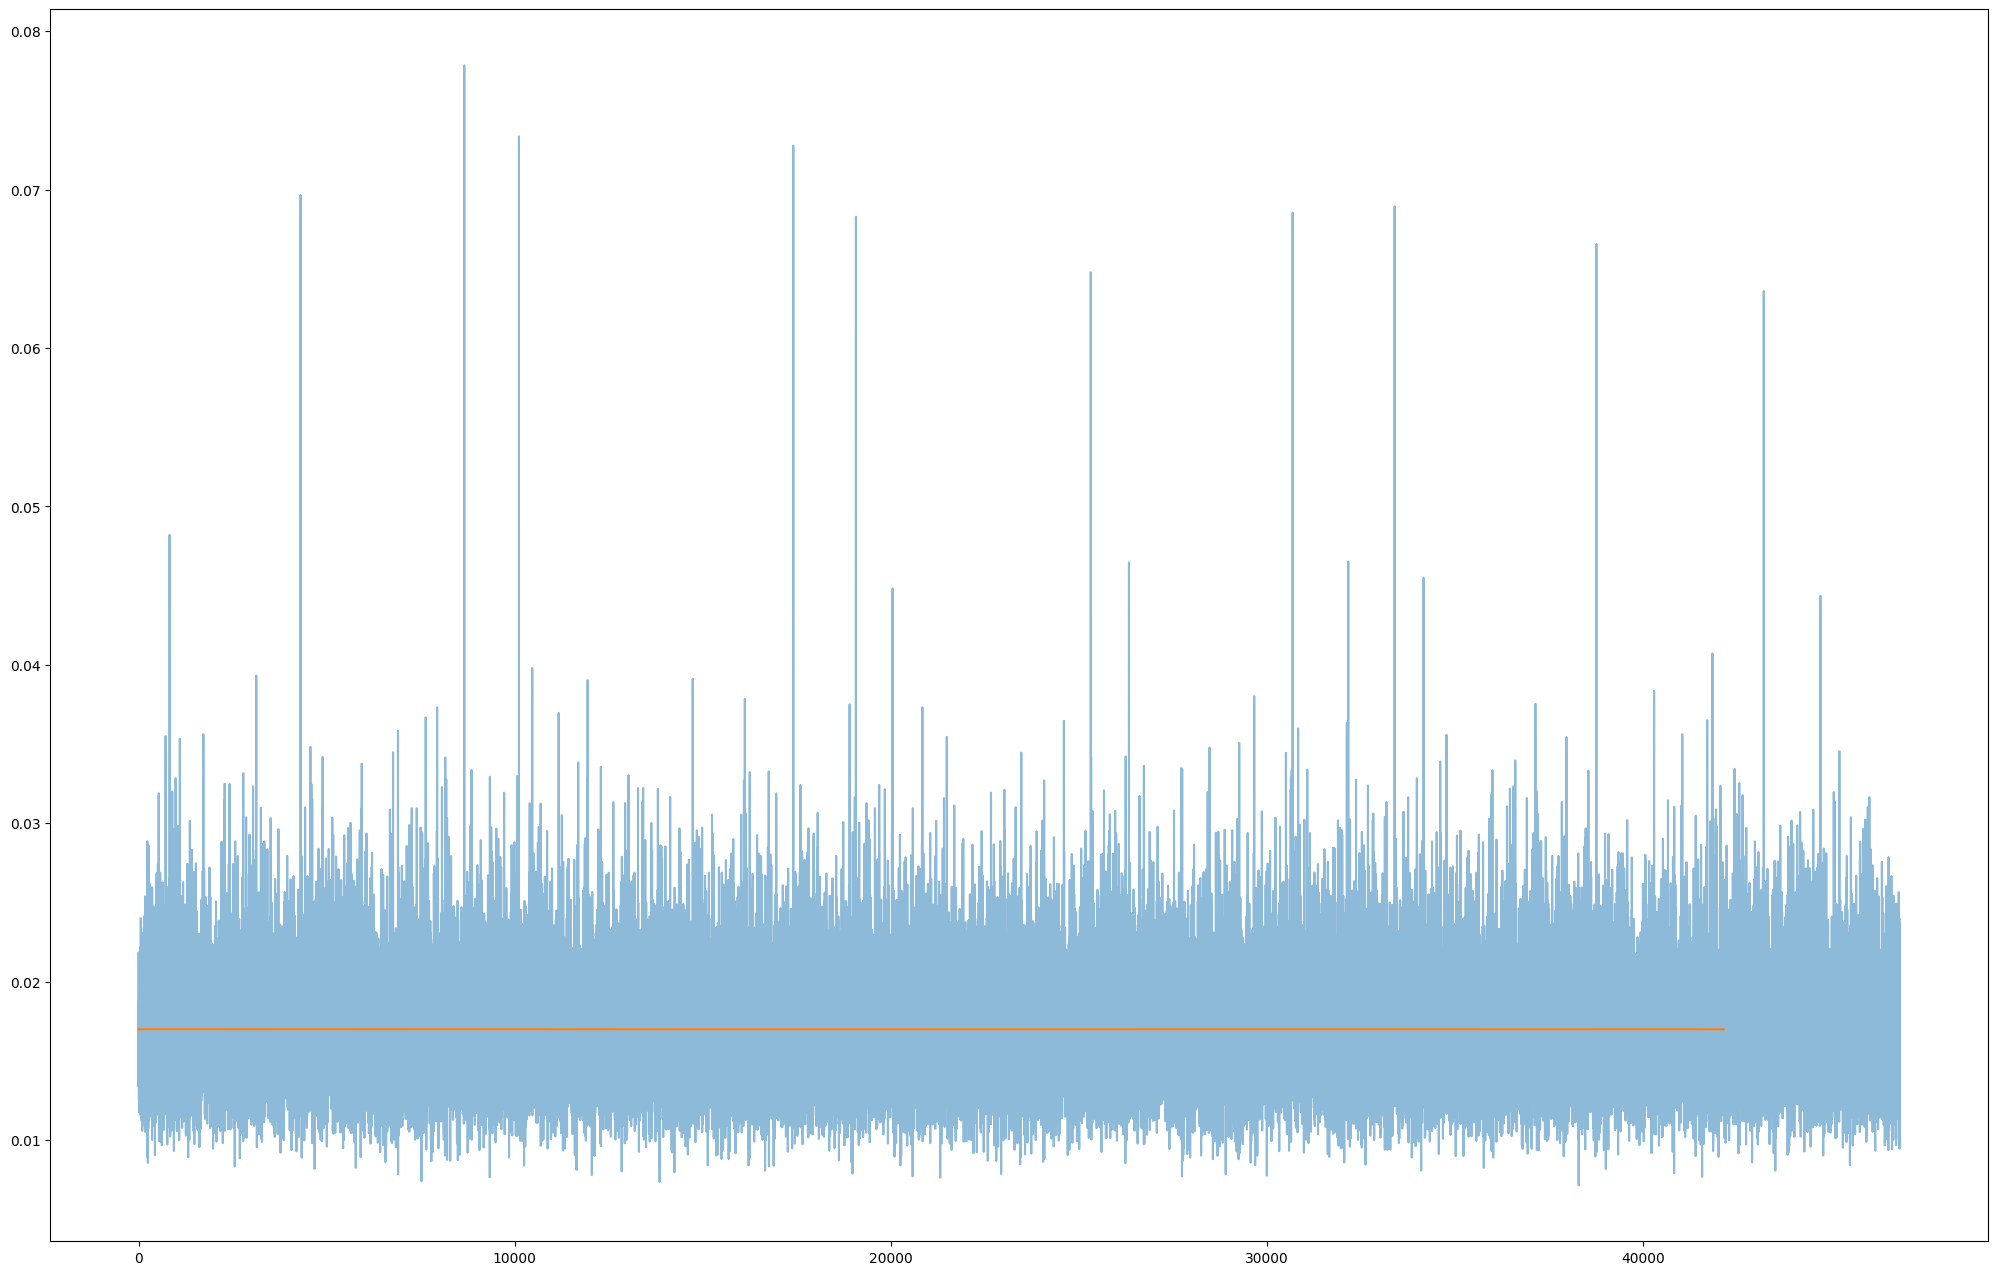

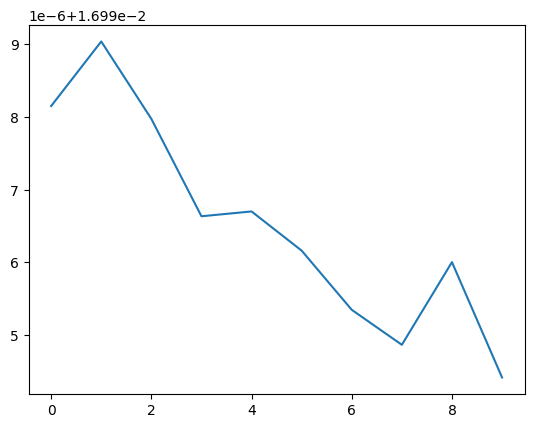

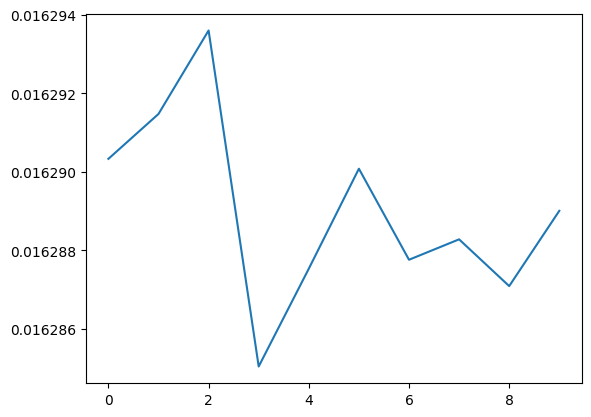

In [23]:
plt.figure(figsize=(25, 16))
plt.plot(train_losses,alpha=0.5)
plt.plot(list(range(0,len(train_losses),int(len(train_losses) / len(avarage_train_losses)))),avarage_train_losses)
plt.show()
plt.plot(avarage_train_losses)
plt.show()
plt.plot(avarage_val_losses)
plt.show()

In [24]:
train_losses_file = open(configs["model_folder"] + "train_losses.txt",'w')
val_losses_file = open(configs["model_folder"] + "val_losses.txt","w")

for value in train_losses :
    train_losses_file.write(f"{value}\n")

for value in val_losses :
    val_losses_file.write(f"{value}\n")

train_losses_file.close()
val_losses_file.close()

In [5]:
best_model = StockLSTM()
best_model.load_state_dict(torch.load(configs["model_folder"] + "LSTM.pth.tar")['model'])

best_model.to(device)
best_model.eval()

StockLSTM(
  (layer1): LSTMBlock(
    (LSTM): LSTM(4, 512, num_layers=2, bias=False, batch_first=True)
    (Dropout): Dropout(p=0.2, inplace=False)
    (LayerNorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (layer2): Linear(in_features=512, out_features=1, bias=False)
)

In [26]:
with torch.no_grad() :
    cur_test_loss = []
    for input,target in tqdm(test_loader) :

        close_price_input = torch.transpose(input[:,1:5,:],1,2)
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        output = best_model(close_price_input)

        loss = loss_fn(output,close_price_target)

        cur_test_loss.append(loss.to(torch.device("cpu")).item())

    avarage_test_loss = np.mean(np.array(cur_test_loss))

print(avarage_test_loss)

  0%|          | 0/2162 [00:00<?, ?it/s]

0.015787786709973033


In [6]:
def get_log_stock_prediction(model, stock_files) :
    model.eval()
    data_set = StockDatasetLogReturn(stock_files, configs["input_size"], 1)
    data_set.Preprocess()
    data_loader = DataLoader(data_set,configs["batch_size"])
    predict_res = []
    target_res = []
    
    with torch.no_grad() : 
        
        for input,target in tqdm(data_loader) :
            close_price_input = torch.transpose(input[:,1:5,:],1,2)
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)

            output = model(close_price_input)

            close_price_input = close_price_input.to(torch.device("cpu"))
            
            predict_res += output.to(torch.device("cpu")).reshape(-1).tolist()
            target_res += close_price_target.to(torch.device("cpu")).reshape(-1).tolist()

    return np.array(predict_res),np.array(target_res)


In [7]:
def trade_test(predict, real) :
    buy_pos = predict > 0
    total_profit = np.exp(np.sum(buy_pos * real))
    return total_profit

In [8]:
def print_trade(best_model, stocks, output_frame) :
    for stock in tqdm(stocks) :
        predict,target = get_log_stock_prediction(best_model, [stock])
        buy_and_hold_profit = trade_test(np.ones(target.shape),target)
        naive_forecast_profit = trade_test(np.concatenate((np.array([0]),(target > 0)))[:-1],target)
        random_profit = trade_test(np.random.randint(low=0,high=2,size=target.shape),target)
        total_profit = trade_test(predict,target)
        inverse_total_profit = trade_test(-predict,target)
        
        new_row = {
            "Name": stock,
            "Buy_and_Hold" : buy_and_hold_profit,
            "Naive_Forecast" : naive_forecast_profit,
            "Random_Profit" : random_profit,
            "Total_Profit" : total_profit,
            "Inverse_Total_Profit" : inverse_total_profit
        }
        
        output_frame.loc[len(output_frame.index)] = new_row

In [9]:
testTickers = list(map(str.strip,open("testTickers.txt","r").readlines()))
test_filenames = ["./data/" + x + ".csv" for x in testTickers]
output_frame = pd.DataFrame(columns=["Name","Buy_and_Hold","Naive_Forecast","Random_Profit","Total_Profit","Inverse_Total_Profit"])
print_trade(best_model,test_filenames,output_frame)
output_frame.to_csv("./out/" + configs["model_name"] + "out.csv",index = False)

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/24177 [00:00<?, ?it/s]

d:\Programming\Pattern_Reg_Final\DatasetLogReturn.py:48: RuntimeWarning: divide by zero encountered in log
  c = np.log(b)


  0%|          | 0/756 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10915 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9589 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6763 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6338 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4937 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3462 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2985 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6129 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11103 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11103 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15668 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8252 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6991 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11315 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10146 [00:00<?, ?it/s]

  0%|          | 0/318 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4012 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15668 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10695 [00:00<?, ?it/s]

  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12889 [00:00<?, ?it/s]

  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12839 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10874 [00:00<?, ?it/s]

d:\Programming\Pattern_Reg_Final\DatasetLogReturn.py:48: RuntimeWarning: divide by zero encountered in log
  c = np.log(b)


  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4222 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4985 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9244 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6656 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10588 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12889 [00:00<?, ?it/s]

  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7728 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10942 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8600 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11103 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/13069 [00:00<?, ?it/s]

  0%|          | 0/409 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7668 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1267 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4964 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9751 [00:00<?, ?it/s]

  0%|          | 0/305 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7172 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3019 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3055 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11591 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6639 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5730 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1273 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15668 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8759 [00:00<?, ?it/s]

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4937 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11103 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11103 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11103 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11103 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10650 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7819 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15668 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1732 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7088 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12875 [00:00<?, ?it/s]

  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7784 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15668 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6231 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9171 [00:00<?, ?it/s]

  0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8147 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3304 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6833 [00:00<?, ?it/s]

  0%|          | 0/214 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15668 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5156 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11155 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7397 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15668 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15668 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1336 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15668 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10038 [00:00<?, ?it/s]

  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11102 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5501 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10923 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5116 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3435 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7414 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8168 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11103 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2942 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4610 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11155 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15668 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11103 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4249 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6575 [00:00<?, ?it/s]

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6479 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9203 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4281 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8017 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2433 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3462 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11103 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6785 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11103 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10772 [00:00<?, ?it/s]

  0%|          | 0/337 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11155 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7139 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11450 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/13009 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11103 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12889 [00:00<?, ?it/s]

  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6677 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

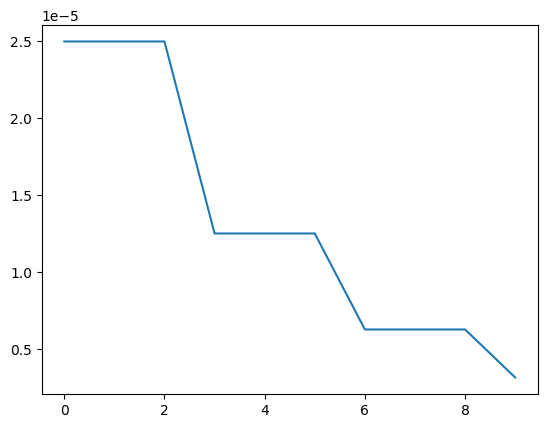

In [31]:
plt.plot(learning_rates)
plt.show()